<a href="https://colab.research.google.com/github/Nilufayeasmin299/Covid19_US_data-for-Twitter_sentiment-analysis/blob/main/Covid19_US_data_for_SA_with_100_dimension_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd


In [ ]:
#Read csv file
df=pd.read_csv('/content/gdrive/My Drive/project for paper /dataset/tencities_15days_april.csv')
df.head()

,twitteDate,tweet_id,created_at,text,loc,user_id,verified,CleanedText,Subjectivity,Polarity,Analysis
0,2020-04-01,1245138809454395392,2020-04-01 00:00:00+00:00,thebsimone during corona stay clean fuck free ...,CA,u282394,0,thebsimon corona stay clean fuck free manit ki...,0.733333,-0.005556,Negative
1,2020-04-01,1245138809920126983,2020-04-01 00:00:00+00:00,balance joining fight against corona turning s...,CA,u460114,0,balanc join fight corona turn shoe product med...,0.000000,0.000000,Neutral
2,2020-04-01,1245138828622471168,2020-04-01 00:00:04+00:00,tory lanez asked young thug been staying coron...,WA,u127769,0,tori lanez ask young thug stay coronafre respo...,0.400000,0.100000,Positive
3,2020-04-01,1245138837057216518,2020-04-01 00:00:06+00:00,hasanthehun donald trump already trying spin c...,FL,u457103,0,hasanthehun donald trump alreadi tri spin coro...,0.000000,0.000000,Neutral
4,2020-04-01,1245138844766416896,2020-04-01 00:00:08+00:00,ghastly corona found into life affected family...,TX,u616396,0,ghast corona found life affect famili lost ano...,0.000000,0.000000,Neutral


### **Let's now see the distribution of sentiments across all the tweets.**

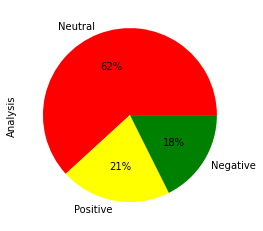

In [ ]:
df.Analysis.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

In [ ]:
df.columns

Index(['twitteDate', 'tweet_id', 'created_at', 'text', 'loc', 'user_id',
       'verified', 'CleanedText', 'Subjectivity', 'Polarity', 'Analysis'],
      dtype='object')

### **We will perform only sentiment analysis so we drop all columns except Cleanedtext and Analysis columns**

In [ ]:
data=df.drop(['twitteDate','tweet_id','created_at','text','loc','user_id','verified','Subjectivity','Polarity'],axis=1)

In [ ]:
data.head()

,CleanedText,Analysis
0,thebsimon corona stay clean fuck free manit ki...,Negative
1,balanc join fight corona turn shoe product med...,Neutral
2,tori lanez ask young thug stay coronafre respo...,Positive
3,hasanthehun donald trump alreadi tri spin coro...,Neutral
4,ghast corona found life affect famili lost ano...,Neutral


In [ ]:
data.shape

(823002, 2)

In [ ]:
#importing all necessary libraries 
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#Here we make our X value which will then be fitted to scikit learning training test split model
X= data['CleanedText'].values
X.shape

(823002,)

In [ ]:
# Creat the function to get label of the dataset
def getSentiment(Analysis):
    if Analysis== 'Negative':
        return 0
    elif Analysis == 'Positive':
        return 1
    else:
      return 2
data['Sentiment']=data['Analysis'].apply(getSentiment)

In [ ]:
data.head()

,CleanedText,Analysis,Sentiment
0,thebsimon corona stay clean fuck free manit ki...,Negative,0
1,balanc join fight corona turn shoe product med...,Neutral,2
2,tori lanez ask young thug stay coronafre respo...,Positive,1
3,hasanthehun donald trump alreadi tri spin coro...,Neutral,2
4,ghast corona found life affect famili lost ano...,Neutral,2


In [ ]:
y= data['Sentiment'].values
y.shape

(823002,)

In [ ]:
# spliting the dataset into train and test


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(658401,) (164601,) (658401,) (164601,)


### **Preparing the Embedding Layer**

In [ ]:
from keras.preprocessing.text import Tokenizer
# we will use the 'Tokenizer' class from the 'keras.preprocessing.text' module to create a word-to-index dictionary.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/My Drive/project for paper /dataset/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### **Bulid LTSM model**

In [ ]:
num_labels = 3
from keras.layers import LSTM
#Defining LTSM model:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(50))
model.add(Dense(num_labels, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 100)          36521700  
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 36,552,053
Trainable params: 30,353
Non-trainable params: 36,521,700
_________________________________________________________________


In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 3

#### **Fit LTSM model**

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/3
8230/8230 [==============================] - 2299s 279ms/step - loss: 0.9295 - acc: 0.6174 - val_loss: 0.9293 - val_acc: 0.6174
Epoch 2/3
8230/8230 [==============================] - 2213s 269ms/step - loss: 0.9295 - acc: 0.6174 - val_loss: 0.9293 - val_acc: 0.6174
Epoch 3/3
8230/8230 [==============================] - 2294s 279ms/step - loss: 0.9295 - acc: 0.6174 - val_loss: 0.9293 - val_acc: 0.6174


Evaluate the model

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

5144/5144 [==============================] - 295s 57ms/step - loss: 0.9262 - acc: 0.6202


**Build CNN model**

In [ ]:
#Defining CNN model
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(num_labels, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          36521700  
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 36,586,215
Trainable params: 64,515
Non-trainable params: 36,521,700
_________________________________________________________________


In [ ]:
#Let's now train our model:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/3
8230/8230 [==============================] - 1925s 234ms/step - loss: 0.1813 - acc: 0.9421 - val_loss: 0.1045 - val_acc: 0.9717
Epoch 2/3
8230/8230 [==============================] - 1776s 216ms/step - loss: 0.0797 - acc: 0.9793 - val_loss: 0.0797 - val_acc: 0.9799
Epoch 3/3
8230/8230 [==============================] - 1747s 212ms/step - loss: 0.0609 - acc: 0.9851 - val_loss: 0.0728 - val_acc: 0.9828


**FIT the model**

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

5144/5144 [==============================] - 205s 40ms/step - loss: 0.0693 - acc: 0.9838
